# Library

In [31]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap

from prml.utils.util import sigmoid,kappa 
from prml.utils.datasets import ClassificationDataGenerator2,RegressionDataGenerator

In [3]:
def f(x):
    return x*x*x - 3*x

def g(x):
    return np.sin(x)

cmaps = [[0.122, 0.467, 0.706],"orange","green"]

# Gaussian Kernel

In [4]:
class GaussianKernel():
    def __init__(self,sigma=0.1):
        super(GaussianKernel,self).__init__()
        self.sigma = sigma 

    def __call__(self, x, y):
        return np.exp(-np.dot(x-y,x-y)/(2*self.sigma**2))

In [5]:
class GramMatrix():
    def __init__(self,sigma=0.1):
        self.kernel_func = GaussianKernel(sigma=sigma)
        
    def __call__(self,X):
        N = X.shape[0] 
        G = np.zeros((N,N))
        for i in range(N):
            G[i] = np.array([self.kernel_func(X[i],X[j]) for j in range(N)])
        return G

# Support Vector Machine

SMO algorithm is used solving a dual problem. Details of this algorithm is written in  <a src = https://www.researchgate.net/publication/2624239_Sequential_Minimal_Optimization_A_Fast_Algorithm_for_Training_Support_Vector_Machines>this paper </a>.

In [13]:
class SupportVectorMachineClassifier():
    def __init__(self,C=20.0,eps=1e-3,sigma=0.5):
        self.kernel_func = GaussianKernel(sigma=sigma)
        self.gram_func = GramMatrix(sigma)
        self.C = C 
        self.eps = eps 
        self.dual_weight = None # alpha
        self.b = None 
        self.support_vector = None 
        self.support_vector_X = None 
        self.support_vector_y = None 

    def fit(self,X,y):
        self.gram_mat = self.gram_func(X) 
        y[y == 0] = -1 
        self.y = y 
        self.dual_weight = np.zeros(X.shape[0])
        self.b = 0
        self.error_cache = self._calc_error()
        self.support_vector = np.arange(X.shape[0])[np.logical_and(self.dual_weight > self.eps,self.dual_weight < self.C - self.eps)] 

        num_changed = 0 
        examin_all = True 
        while num_changed > 0 or examin_all:
            num_changed = 0 
            if examin_all:
                for i in range(X.shape[0]):
                    num_changed += self._examin_example(i)
            else:
                for i in self.support_vector:
                    num_changed += self._examin_example(i) 
            if examin_all:
                examin_all = False 
            elif num_changed == 0:
                examin_all = True
            
        self.support_vector_X = X[self.support_vector] 
        self.support_vector_y = y[self.support_vector]
        self.dual_weight = self.dual_weight[self.support_vector] 

        del self.gram_mat,self.y,self.error_cache # for memory
    
    def _examin_example(self,i2):
        y2 = self.y[i2] 
        alpha2 = self.dual_weight[i2] 
        E2 = self.error_cache[i2] 
        r2 = E2*y2 # equals ui*yi - 1
        if (r2 < -self.eps and alpha2 < self.C) or (r2 > self.eps and alpha2 > 0): # violate KKT conditions 
            if len(self.support_vector) > 1:
                i1 = np.argmax(np.abs(self.error_cache - E2)) 
                if self._take_step(i1,i2,y2,alpha2,E2):
                    return 1  
            for i1 in self.support_vector:
                if self._take_step(i1,i2,y2,alpha2,E2):
                    return 1  
            for i1 in range(self.y.shape[0]):
                if self._take_step(i1,i2,y2,alpha2,E2):
                    return 1 
        return 0 
    
    def _take_step(self,i1,i2,y2,alpha2,E2):
        if i1 == i2:
            return False 
        alpha1 = self.dual_weight[i1] 
        y1 = self.y[i1] 
        E1 = self.error_cache[i1]

        L,H = self._calc_bound(y1,y2,alpha1,alpha2)
        if L == H:
            return False  
        
        eta = self.gram_mat[i1,i1] - 2*self.gram_mat[i1,i2] + self.gram_mat[i2,i2]
        a2 = alpha2 + y2*(E1 - E2)/eta
        if a2 < L:
            a2 = L 
        elif a2 > H:
            a2 = H 
        
        if abs(a2 - alpha2) < self.eps*(a2 + alpha2 + self.eps): # change is too small
            return False  
        
        a1 = alpha1 + y1*y2*(alpha2 - a2) 
        self._update_threshold(i1,i2,alpha1,alpha2,a1,a2,y1,y2,E1,E2)
        self.dual_weight[i1] = a1 
        self.dual_weight[i2] = a2 
        self.error_cache = self._calc_error() # more faster update is possible 
        self.support_vector = np.arange(self.y.shape[0])[np.logical_and(self.dual_weight > self.eps,self.dual_weight < self.C - self.eps)] 

        return True 

    def _calc_bound(self,y1,y2,alpha1,alpha2):
        if y1 != y2:
            diff = alpha2 - alpha1
            L = max(0,diff)
            H = min(self.C,self.C + diff)
        else:
            total = alpha1 + alpha2
            L = max(0,total - self.C) 
            H = min(self.C,total) 
        return L,H   

    def _calc_error(self):
        pred = np.dot(self.gram_mat.T,self.dual_weight*self.y) + self.b 
        E = pred - self.y
        return E 
    
    def _update_threshold(self,i1,i2,alpha1,alpha2,a1,a2,y1,y2,E1,E2):
        if 0 < a1 < self.C:
            self.b -= E1 + y1*(a1 - alpha1)*self.gram_mat[i1,i1] + y2*(a2 - alpha2)*self.gram_mat[i1,i2] 
        elif 0 < a2 < self.C: 
            self.b -= E2 + y1*(a1 - alpha1)*self.gram_mat[i1,i2] + y2*(a2 - alpha2)*self.gram_mat[i2,i2] 
        else:
            b1 = E1 + y1*(a1 - alpha1)*self.gram_mat[i1,i1] + y2*(a2 - alpha2)*self.gram_mat[i1,i2] 
            b2 = E2 + y1*(a1 - alpha1)*self.gram_mat[i1,i2] + y2*(a2 - alpha2)*self.gram_mat[i2,i2]  
            self.b -= (b1 + b2)/2
        return 
    
    def predict(self,X):
        gram_mat = np.zeros((self.support_vector_X.shape[0],X.shape[0]))
        for i in range(self.support_vector_X.shape[0]):
            gram_mat[i] = np.array([self.kernel_func(self.support_vector_X[i],X[j]) for j in range(X.shape[0])]) 
        
        sign_y = np.dot(gram_mat.T,self.dual_weight*self.support_vector_y) + self.b 
        y = np.zeros(X.shape[0])
        y[sign_y > 0] = 1 
        y[sign_y <= 0] = 0 
        return y 
    
    def number_of_support_vector(self):
        return len(self.support_vector) 
    
    def index_of_support_vector(self):
        return self.support_vector

In [14]:
gen = ClassificationDataGenerator2(f)
n_data = 200
X_tr,y_tr = gen(encoding="label",x_lower=-3,x_upper=3,y_lower=-3,y_upper=3,n=n_data)  

svm = SupportVectorMachineClassifier(C=100.0,sigma=0.5)
svm.fit(X_tr,y_tr)
print(f"number of support vector {svm.number_of_support_vector()}")
print(f"number of data {n_data}")

cmap = ListedColormap(["red","blue"])

# prepare data 
x_min,y_min = X_tr.min(axis = 0)
x_max,y_max = X_tr.max(axis = 0) 
x_min,y_min = x_min-0.1,y_min-0.1
x_max,y_max = x_max+0.1,y_max+0.1
x = np.linspace(x_min,x_max,100)
y = np.linspace(y_min,y_max,100) 
xs,ys = np.meshgrid(x,y)

# predict 
labels = svm.predict(np.array([xs.ravel(),ys.ravel()]).T)
labels = labels.reshape(xs.shape)

number of support vector 61
number of data 200


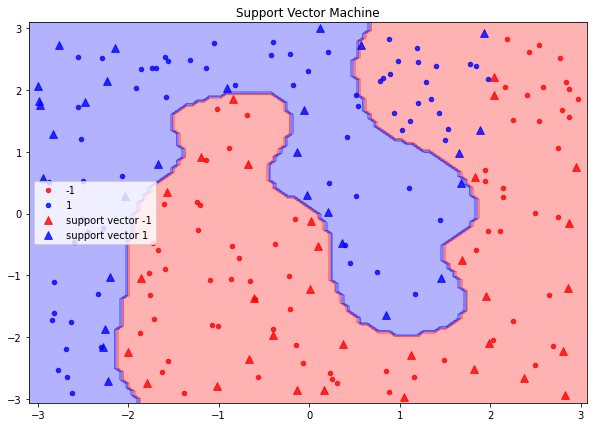

In [15]:
# plot 
figure,axes = plt.subplots(1,1,figsize=(10,7))
axes.contourf(xs,ys,labels,alpha=0.3,cmap=cmap)
axes.set_xlim(x_min,x_max)
axes.set_ylim(y_min,y_max)

ind_support_vector = svm.index_of_support_vector() 
not_support_vector = np.logical_not(np.isin(np.arange(n_data),ind_support_vector))
X_notsv,y_notsv = X_tr[not_support_vector],y_tr[not_support_vector]
X_sv,y_sv = X_tr[ind_support_vector],y_tr[ind_support_vector] 
axes.scatter(x=X_notsv[y_notsv == -1,0],y=X_notsv[y_notsv == -1,1],alpha=0.8,c="red",label=-1,s=20)
axes.scatter(x=X_notsv[y_notsv == 1,0],y=X_notsv[y_notsv == 1,1],alpha=0.8,c="blue",label=1,s=20)

axes.scatter(x=X_sv[y_sv == -1,0],y=X_sv[y_sv == -1,1],alpha=0.8,c="red",label=f"support vector {-1}",marker="^",s=60)
axes.scatter(x=X_sv[y_sv == 1,0],y=X_sv[y_sv == 1,1],alpha=0.8,c="blue",label=f"support vector {1}",marker="^",s=60)

axes.set_title("Support Vector Machine")
plt.legend()
plt.show()

# Relevance Vector Machine for Regression

In [16]:
class RelevanceVectorMachineRegressor():
    def __init__(self,alpha=None,beta=None,max_iter=100,threshold=1e-7,sigma=0.1):
        self.kernel_func = GaussianKernel(sigma=sigma)
        self.gram_func = GramMatrix(sigma)
        self.alpha = alpha 
        self.beta = beta 
        self.max_iter = max_iter
        self.threshold = threshold
        self.weight = None 
        self.sigma = None 
        self.relevance_vector = None 
        self.relevance_vector_X = None 

    def fit(self,X,y):

        design_mat = self.gram_func(X) 
        if self.alpha is None:
            self.alpha = np.random.randn(design_mat.shape[1]) 
        if self.beta is None:
            self.beta = np.random.randn(1)[0]

        self.sigma = np.linalg.inv(np.diag(self.alpha) + self.beta*design_mat.T@design_mat) 
        self.weight = self.beta*self.sigma@design_mat.T@y 

        self._optimize(design_mat,X,y)

    def _optimize(self,design_mat,X,y):
        N = design_mat.shape[0] 

        for _ in range(self.max_iter): 
            gamma = 1 - np.diag(self.sigma)*self.alpha  
            self.alpha = gamma/self.weight.ravel()**2 
            self.alpha = np.clip(self.alpha,0,1e10)
            self.beta = (N - gamma.sum()) / np.sum((y - design_mat@self.weight)**2)
            self.sigma = np.linalg.pinv(np.diag(self.alpha) + self.beta*design_mat.T@design_mat) 
            weight = self.beta*self.sigma@design_mat.T@y 
            if np.mean((weight - self.weight)**2) < self.threshold:
                self.weight = weight
                break 
            self.weight = weight
        
        relevance_vector = np.abs(self.weight) > 1e-3
        self.weight = self.weight[relevance_vector].reshape(-1,1)
        n = self.weight.shape[0]
        self.sigma = self.sigma[np.logical_and(relevance_vector,relevance_vector.ravel())].reshape(n,n)
        self.relevance_vector = np.arange(N)[relevance_vector.ravel()].reshape(-1,1)
        self.relevance_vector_X = X[relevance_vector].reshape(-1,1)
    
    def predict(self,X,return_std=False):

        design_mat = np.zeros((self.relevance_vector_X.shape[0],X.shape[0]))
        for i in range(self.relevance_vector_X.shape[0]):
            design_mat[i] = np.array([self.kernel_func(self.relevance_vector_X[i],X[j]) for j in range(X.shape[0])]) 
        
        y = design_mat.T@self.weight 
        if return_std:
            std = 1/self.beta + np.diag(design_mat.T@self.sigma@design_mat) 
            return y,std.reshape(-1,1) 
        else:
            return y
    
    def number_of_relevance_vector(self):
        return len(self.relevance_vector) 
    
    def index_of_relevance_vector(self):
        return self.relevance_vector

number of relevance vector: 6
number of daat: 100
RMSE : 0.04977997407772772


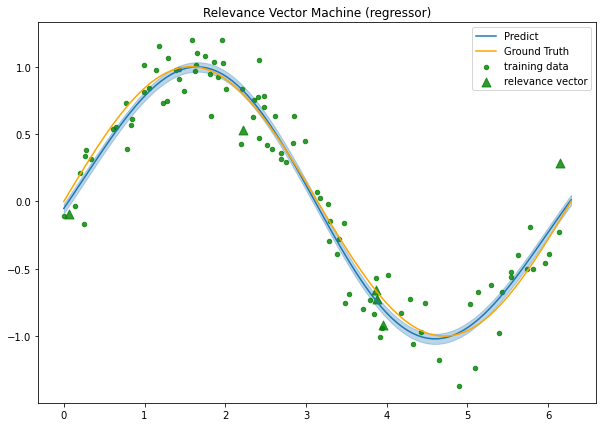

In [22]:
# training 
n_data = 100
rvm = RelevanceVectorMachineRegressor(sigma=2,max_iter=1000) 
generator = RegressionDataGenerator(g)

X_tr,y_tr = generator(lower=0,upper=2*np.pi,std=0.2,n=n_data)  
rvm.fit(X_tr,y_tr) 
print(f"number of relevance vector: {rvm.number_of_relevance_vector()}")
print(f"number of daat: {n_data}")

# inference
X = np.linspace(0,2*np.pi,100).reshape(-1,1)
y_pred,y_std = rvm.predict(X,return_std=True)
y_true = g(X)

rmse = np.mean((y_pred - y_true)**2)**0.5
print(f"RMSE : {rmse}")

fig,ax = plt.subplots(1,1,figsize = (10,7))
ax.plot(X,y_pred,label="Predict",color=cmaps[0])

y_pred_upper = y_pred + y_std
y_pred_lower = y_pred - y_std 
ax.fill_between(X.ravel(),y_pred_lower.ravel(),y_pred_upper.ravel(),alpha=0.3,color=cmaps[0])

ax.plot(X,y_true,label="Ground Truth",color=cmaps[1])
ax.set_title("Relevance Vector Machine (regressor)")

ind_relevance_vector = rvm.index_of_relevance_vector()
not_relevance_vector = np.logical_not(np.isin(np.arange(n_data),ind_relevance_vector))
X_notrv,y_notrv = X_tr[not_relevance_vector],y_tr[not_relevance_vector]
X_rv,y_rv = X_tr[ind_relevance_vector],y_tr[ind_relevance_vector] 
ax.scatter(x=X_notrv[:,0],y=y_notrv[:,0],alpha=0.8,c=cmaps[2],label="training data",s=20)
ax.scatter(x=X_rv[:,0],y=y_rv[:,0],alpha=0.8,c=cmaps[2],label=f"relevance vector",marker="^",s=80)

plt.legend()
plt.show()

#  Relevance Vector Machine for Classification

In [29]:
class RelevanceVectorMachineClassifier():
    def __init__(self,alpha=None, max_iter=100,threshold=1e-7, sigma=0.1):
        self.kernel_func = GaussianKernel(sigma=sigma)
        self.gram_func = GramMatrix(sigma)
        self.alpha = alpha 
        self.max_iter = max_iter 
        self.threshold = threshold 
        self.weight = None 
        self.sigma = None
        self.relevance_vector = None 
        self.relevance_vector_X = None  

    def fit(self,X,y): 
        y = y.reshape(-1,1)

        design_mat = self.gram_func(X) 
        self.weight = np.random.randn(design_mat.shape[1],1) 
        if self.alpha is None:
            self.alpha = np.random.rand(design_mat.shape[1],1) 

        for i in range(self.max_iter):
            self.sigma = self._optimize_weight(design_mat,y,max_iter=100)
            new_alpha = self._optimize_parameter(max_iter=1) # if max_iter is more than 1, doesn't work well
            n = np.sum((new_alpha != 1e10).astype("int"))
            if (np.sum((new_alpha - self.alpha)**2)/n)**0.5 < self.threshold:
                self.alpha = new_alpha
                break 
            self.alpha = new_alpha  

        relevance_vector = np.abs(self.weight) > 1e-3
        self.weight = self.weight[relevance_vector].reshape(-1,1)
        n = self.weight.shape[0]
        self.sigma = self.sigma[np.logical_and(relevance_vector,relevance_vector.ravel())].reshape(n,n)
        self.relevance_vector = np.arange(X.shape[0])[relevance_vector.ravel()].reshape(-1,1)
        self.relevance_vector_X = X[relevance_vector.ravel()]
    
    def _optimize_weight(self,design_mat,y,max_iter):
        # Newton method 
        for _ in range(max_iter):
            y_pred = sigmoid(design_mat@self.weight) 
            grad = self.alpha*self.weight - design_mat.T@(y - y_pred) 
            B = y_pred*(1 - y_pred)
            H_inv = np.linalg.pinv(design_mat.T@(B*design_mat) + np.diag(self.alpha.ravel()))  
            self.weight -=  H_inv@grad
        return H_inv 
    
    def _optimize_parameter(self,max_iter):
        alpha = self.alpha
        for _ in range(max_iter):
            gamma = 1 - alpha*np.diag(self.sigma).reshape(-1,1) 
            alpha = gamma/self.weight**2 
            alpha = np.clip(alpha,0,1e10)  
        return alpha 

    def predict(self,X,return_prob=False):
        design_mat = np.zeros((self.relevance_vector_X.shape[0],X.shape[0]))
        for i in range(self.relevance_vector_X.shape[0]):
            design_mat[i] = np.array([self.kernel_func(self.relevance_vector_X[i],X[j]) for j in range(X.shape[0])]) 
        
        logit = (design_mat.T@self.weight).ravel() 
        if return_prob:
            sigma = np.diag(design_mat.T@self.sigma@design_mat) 
            prob = sigmoid(kappa(sigma)*logit) 
            return prob  
        else:
            y = np.zeros(X.shape[0])
            y[logit >= 0] = 1
            return y 
    
    def number_of_relevance_vector(self):
        return len(self.relevance_vector) 
    
    def index_of_relevance_vector(self):
        return self.relevance_vector

Number of relevance vector: 11
Number of data: 50


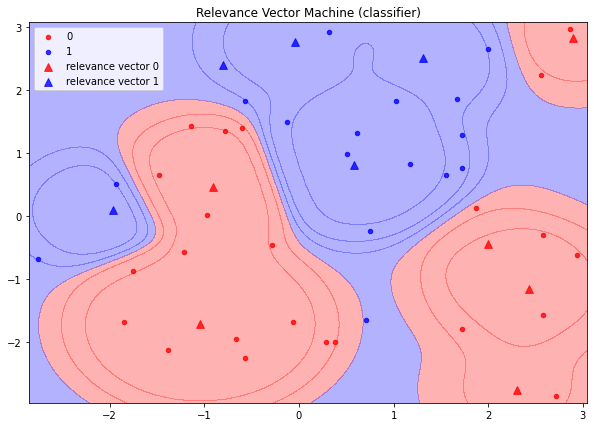

In [33]:
gen = ClassificationDataGenerator2(f)
n_data = 50
X_tr,y_tr = gen(encoding="label",x_lower=-3,x_upper=3,y_lower=-3,y_upper=3,n=n_data)  
#X_tr,y_tr = gen(encoding="label",x_lower=0,x_upper=7,y_lower=0,y_upper=7,n=n_data)  

rvm = RelevanceVectorMachineClassifier(max_iter=100,threshold=1e-8,sigma=0.5)
rvm.fit(X_tr,y_tr)


print(f"Number of relevance vector: {rvm.number_of_relevance_vector()}")
print(f"Number of data: {n_data}")

cmap = ListedColormap(["red","blue"])

# prepare data 
x_min,y_min = X_tr.min(axis = 0)
x_max,y_max = X_tr.max(axis = 0) 
x_min,y_min = x_min-0.1,y_min-0.1
x_max,y_max = x_max+0.1,y_max+0.1
x = np.linspace(x_min,x_max,100)
y = np.linspace(y_min,y_max,100) 
xs,ys = np.meshgrid(x,y)

# predict 
probs = rvm.predict(np.array([xs.ravel(),ys.ravel()]).T,return_prob=True)
probs = probs.reshape(xs.shape)

figure,axes = plt.subplots(1,1,figsize=(10,7))
axes.contourf(xs,ys,probs,alpha=0.3,cmap=cmap)
axes.set_xlim(x_min,x_max)
axes.set_ylim(y_min,y_max)

ind_relevance_vector = rvm.index_of_relevance_vector() 
not_relevance_vector = np.logical_not(np.isin(np.arange(n_data),ind_relevance_vector))
X_notrv,y_notrv = X_tr[not_relevance_vector],y_tr[not_relevance_vector]
X_rv,y_rv = X_tr[ind_relevance_vector],y_tr[ind_relevance_vector] 
axes.scatter(x=X_notrv[y_notrv == 0,0],y=X_notrv[y_notrv == 0,1],alpha=0.8,c="red",label=0,s=20)
axes.scatter(x=X_notrv[y_notrv == 1,0],y=X_notrv[y_notrv == 1,1],alpha=0.8,c="blue",label=1,s=20)

axes.scatter(x=X_rv[y_rv == 0,0],y=X_rv[y_rv == 0,1],alpha=0.8,c="red",label=f"relevance vector {0}",marker="^",s=60)
axes.scatter(x=X_rv[y_rv == 1,0],y=X_rv[y_rv == 1,1],alpha=0.8,c="blue",label=f"relevance vector {1}",marker="^",s=60)

axes.set_title("Relevance Vector Machine (classifier)")
plt.legend()
plt.show()